In [39]:
import gymnasium as gym
import math
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
import matplotlib 
from IPython import display


env = gym.make("CartPole-v1")
plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Transition = namedtuple("Transition", ('state', 'action', 'next_state', 'reward'))

In [40]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
LR = 1e-4
TAU = 0.005
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
steps_done = 0
episode_durations = []

In [41]:
angle = ctrl.Antecedent(np.arange(-0.42, 0.42, 0.01), 'angle')
velocity = ctrl.Antecedent(np.arange(-3.5, 3.5, 0.1), 'velocity')
action = ctrl.Consequent(np.arange(0, 2, 1), 'action')
angle.automf(3)
velocity.automf(3)
action['push_left'] = fuzz.trimf(action.universe, [0, 0, 1])
action['push_right'] = fuzz.trimf(action.universe, [1, 1, 2])
rule1 = ctrl.Rule(angle['poor'] & velocity['poor'], action['push_left'])
rule2 = ctrl.Rule(angle['good'] & velocity['good'], action['push_right'])
action_ctrl = ctrl.ControlSystem([rule1, rule2])
action_sim = ctrl.ControlSystemSimulation(action_ctrl)

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

def plot_durations():
    plt.figure(1)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    plt.pause(0.001)  # pause a bit so that plots are updated
    if 'inline' in matplotlib.get_backend():
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        plt.show()

In [42]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

num_episodes = 500 if not torch.cuda.is_available() else 600
for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        next_state = None if terminated else torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        memory.push(state, action, next_state, reward)
        state = next_state
        optimize_model()
        for key in policy_net.state_dict():
            target_net.state_dict()[key] = policy_net.state_dict()[key]*TAU + target_net.state_dict()[key]*(1-TAU)
        target_net.load_state_dict(target_net.state_dict())
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
print('Complete')
plt.ioff()
plt.show()


Complete


<Figure size 640x480 with 0 Axes>

In [43]:
torch.save(policy_net.state_dict(), 'policy_net_complete.pth')



Episode 1/10 - Total reward: 8.0
Episode 2/10 - Total reward: 9.0
Episode 3/10 - Total reward: 10.0
Episode 4/10 - Total reward: 9.0
Episode 5/10 - Total reward: 10.0
Episode 6/10 - Total reward: 11.0
Episode 7/10 - Total reward: 10.0
Episode 8/10 - Total reward: 9.0
Episode 9/10 - Total reward: 9.0
Episode 10/10 - Total reward: 8.0


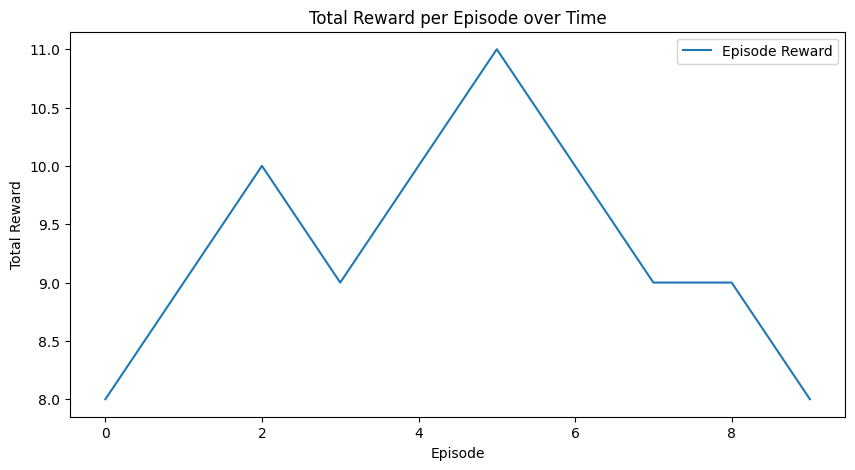

Average reward over 10 episodes: 9.3


In [50]:
import gymnasium as gym
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_observations = 4
n_actions = 2

# Load the model
policy_net = DQN(n_observations, n_actions).to(device)
policy_net.load_state_dict(torch.load('target_net_complete.pth'))
policy_net.eval()

env = gym.make("CartPole-v1", render_mode="human")

num_episodes = 10  # Number of episodes to simulate
episode_rewards = []

for episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    is_done = False
    total_reward = 0

    while not is_done:
        with torch.no_grad():
            action = policy_net(state).max(1)[1].view(1, 1)
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        total_reward += reward
        state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
        is_done = terminated or truncated

        env.render()
        plt.pause(0.01)

    episode_rewards.append(total_reward)
    print(f'Episode {episode + 1}/{num_episodes} - Total reward: {total_reward}')

env.close()

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards, label='Episode Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode over Time')
plt.legend()
plt.show()

# Display average reward
average_reward = np.mean(episode_rewards)
print(f'Average reward over {num_episodes} episodes: {average_reward}')



In [47]:
env.close()